#Paquetes necesarios

In [1]:
# os is used for Ilka's linux :)
import os
os.environ["QT_QPA_PLATFORM"] = "xcb"

import cv2  
import numpy as np
import matplotlib.pyplot as plt

Carga imagen y convierte a RGB

(938, 473, 3)


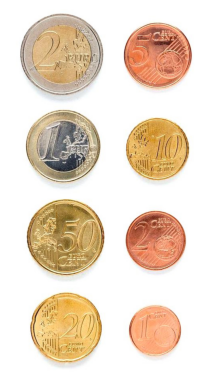

In [2]:
#Carga imagen ejemplo con monedas
img = cv2.imread('Monedas.jpg') 
print(img.shape)
#Recordar que OpenCV lee las imágenes en BGR, por lo que convertimos para visualizr a RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(img_rgb) 
plt.show()

TAREA: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.



In [3]:
# TAREA 1 - valores constantes

img = cv2.imread('Foto_Monedas.jpg') 

indexToCents = {
    0: 200,
    1: 100,
    2: 50,
    3: 20,
    4: 10,
    5: 5, 
    6: 2,
    7: 1
}

size_mm = {
    200 : 25.75,
    100 : 23.25,
    50  : 24.35,
    20  : 22.25,
    10  : 19.75,
    5   : 21.25,
    2   : 18.75,
    1   : 16.25
}

#
size_relation = np.ones((len(size_mm), len(size_mm)))
len_size_mm = len(size_mm)
i=0
for x in size_mm:
    j=0
    for y in size_mm:
        size_relation[i,j] = float(size_mm[x]/size_mm[y])
        j = j+1
    i = i+1

class Coin:
    value = 0
    potential = list(range(8))
    color = (0,0,0)
    size = 0
    relation = 0
    position = (0,0)
    diameter = 0
    contour = None

bronze = "red"
gold = "gold"


print(size_relation)
# testcoin = Coin()
# print("test:", testcoin.potential)

def findMatchingSize(coin1, coin2):

    relat = coin1.diameter / coin2.diameter
    # Initialize variables to keep track of the two closest values and their indices
    closest_diff_1 = float('inf')
    closest_index_1 = (-1, -1)
    
    closest_diff_2 = float('inf')
    closest_index_2 = (-1, -1)
    
    # Iterate through the array
    for i in range(len(size_relation)):
        for j in range(len(size_relation[i])):
            # Calculate the difference between the current element and the target
            diff = abs(size_relation[i][j] - relat)
            
            # Check if this difference is smaller than the closest one
            if diff < closest_diff_1:
                # Move the first closest to second closest
                closest_diff_2, closest_index_2 = closest_diff_1, closest_index_1
                # Update the closest one
                closest_diff_1, closest_index_1 = diff, (i, j)
            
            # If it is larger than the closest but smaller than the second closest
            elif diff < closest_diff_2:
                closest_diff_2, closest_index_2 = diff, (i, j)
    
    # first entry for coin1, second for coin2
    return closest_index_1, closest_index_2
     
# get average color of a contour
def getAvgColor(image, contour):
    # Create a mask with the same dimensions as the image, initialized to 0 (black)
    mask = np.zeros(image.shape[:2], dtype="uint8")
    
    # Fill the contour on the mask with white (255)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    
    # Calculate the mean of the image only where the mask is non-zero (i.e., inside the contour)
    mean_color = cv2.mean(image, mask=mask)
    
    # The result is in BGR format; we'll discard the alpha channel (the last element)
    return mean_color[:3] 



[[1.         1.10752688 1.05749487 1.15730337 1.30379747 1.21176471
  1.37333333 1.58461538]
 [0.90291262 1.         0.95482546 1.04494382 1.17721519 1.09411765
  1.24       1.43076923]
 [0.94563107 1.04731183 1.         1.09438202 1.23291139 1.14588235
  1.29866667 1.49846154]
 [0.86407767 0.95698925 0.9137577  1.         1.12658228 1.04705882
  1.18666667 1.36923077]
 [0.76699029 0.84946237 0.8110883  0.88764045 1.         0.92941176
  1.05333333 1.21538462]
 [0.82524272 0.91397849 0.87268994 0.95505618 1.07594937 1.
  1.13333333 1.30769231]
 [0.72815534 0.80645161 0.77002053 0.84269663 0.94936709 0.88235294
  1.         1.15384615]
 [0.63106796 0.69892473 0.66735113 0.73033708 0.82278481 0.76470588
  0.86666667 1.        ]]


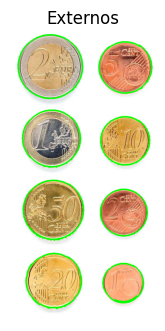

In [4]:
# TAREA 1 - calcular

img = cv2.imread('Monedas.jpg') 
coins = []

# Umbralizado binario invertido, dado que por defecto se asume objetos en blanco
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
th1,img_th1 = cv2.threshold(img_gris,200,255,cv2.THRESH_BINARY_INV)

#Obtiene únicamente los contornos externos
contornos, _ = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

#Dibuja sobre la imagen de entrada sólo contornos externos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

plt.subplot(132)
plt.axis("off")
#cv2.imshow("output", img_rgb)
plt.title('Externos')
plt.imshow(img_rgb) 


#Imagen negra
img_cont = np.zeros(img_rgb.shape)

diameters = []
#Recorre los contornos externos
for c in contornos:
    #Área del contorno
    area = cv2.contourArea(c)
    #Área mínima (útil filtrar en ocasiones)
    if area > 50:
        currentCoin = Coin()
        #Perímetro del contorno
        #currentCoin.diameter = cv2.arcLength(c,True)
        (x,y),radio = cv2.minEnclosingCircle(c)
        currentCoin.diameter = radio *2
        #Contenedor alineado con ejes de la imagen
        #x,y,w,h = cv2.boundingRect(c)
        #currentCoin.position = (x+w/2,y-h/2)
        currentCoin.position = (x,y)
        currentCoin.contour = c

        # get color
        currentCoin.color = getAvgColor(img, c)
        #print("relation: rg", currentCoin.color[2]/currentCoin.color[0], 'rb:', currentCoin.color[2]/currentCoin.color[1])
        
        if (currentCoin.color[2] >= 210):
            currentCoin.potential = [5,6,7]
        else:
            currentCoin.potential = [0,1,2,3,4]

        coins.append(currentCoin)


for i in range(len(coins)):
    if len(coins[i].potential) != 1:
        # check with the relation of the contours
        for s in coins:
            pair1, pair2 = findMatchingSize(coins[i], s)
            candidates = [pair1[0], pair2[0]]
            cut = list(set(coins[i].potential) & set(candidates))
            if len(cut) != 0:
                coins[i].potential = cut

# match value to current guess and compute total
total = 0
for i in range(len(coins)):
    if len(coins[i].potential) == 1:
        coins[i].value = indexToCents[coins[i].potential[0]]
        total = total + coins[i].value 

total = total / 100
# for c in coins:
#     print(c.position, c.color)



In [5]:
# Function to check if click is inside a coin's area
def is_click_in_coin(click_x, click_y, coin):
    coin_x, coin_y = coin.position
    radius = coin.diameter / 2
    # Calculate distance between the click point and the center of the coin
    distance = np.sqrt((click_x - coin_x)**2 + (click_y - coin_y)**2)
    return distance <= radius
# Definir los valores en función del diámetro (mayor a menor)
# El índice corresponderá al diámetro, por lo que ajustaremos el código
indexToCents = {
    0: 200,  # 2 euros
    1: 50,  # 1 euro
    2: 100,   # 50 centavos
    3: 20,   # 20 centavos
    4: 5,   # 5 centavos
    5: 10,    # 10 centavos
    6: 2,    # 2 centavos
    7: 1     # 1 centavo
}

# Actualizar el código que asigna los valores en función del diámetro.
# Aquí se ordenan las monedas por su tamaño y se asignan valores basados en la lista de indexToCents.

# Asignación del valor a las monedas
# Primero ordenamos las monedas según su diámetro
coins_sorted_by_size = sorted(coins, key=lambda c: c.diameter, reverse=True)

# Luego, asignamos valores en función de su posición en la lista ordenada
# for i, coin in enumerate(coins_sorted_by_size):
#     if i < len(indexToCents):  # Asegurarse de no superar el índice del diccionario
#         coin.value = indexToCents[i]
#     else:
#         coin.value = 0  # Para manejar cualquier caso inesperado

# Ahora las monedas tienen asignado su valor correcto basándose en su tamaño


total_cents = sum([coin.value for coin in coins if isinstance(coin.value, int)])

# Convertir el total a euros
total_euros = total_cents / 100


# Función de evento click modificada para mostrar el valor correcto
def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print('You clicked at: ', x, y)
        # Iterar por cada moneda para ver si el clic está dentro del área de la moneda
        for coin in coins:
            if is_click_in_coin(x, y, coin):
                # Dibujar el valor de la moneda en la imagen
                img_with_value = img.copy()

                # Mostrar el valor de la moneda
                if hasattr(coin, 'value'):
                    coin_value = coin.value
                else:
                    coin_value = "No definido"

                print("Clicked on coin at position: ", coin.position, " value: ", coin.value)

                # Escribir el valor en la imagen
                cv2.putText(img_with_value, f'{coin_value/100} Euro', (x, y), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

                # Mostrar la imagen con el valor de la moneda
                cv2.imshow('Coins', img_with_value)
                break

# Load the image
img = cv2.imread('Monedas.jpg')
cv2.putText(img, f'total: {total} Euro', (10,img.shape[0]-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

cv2.imshow('Coins', img)

# Set mouse callback function for the window
cv2.setMouseCallback('Coins', click_event)

# Display the image and wait for the ESC key to exit
while True:
    if cv2.waitKey(20) == 27:
        break

# Destroy all windows when done
cv2.destroyAllWindows()

print(f"El precio total de todas las monedas es: {total_euros:.2f} euros")
    

KeyboardInterrupt: 

El mundo real es muy variado, las imágenes no siempre se capturan con unas condiciones de iluminación tan buenas o controladas. Ejemplo con aplicación de variantes de umbralizados ofrecidas por OpenCV.

Umbral escogido  197.0


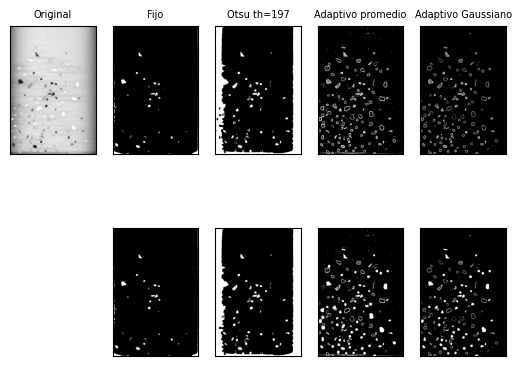

In [6]:
#Carga imagen directamente en grises
imgorig = cv2.imread('MPs.jpg', cv2.IMREAD_GRAYSCALE) 

img = cv2.GaussianBlur(imgorig,(5,5),0)

#Umbralizados
ret,imth1 = cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
thotsu,imth2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral escogido ', thotsu)
imth3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
imth4 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
 
titles = ['Original', 'Fijo','Otsu th='+str(int(thotsu)),
            'Adaptivo promedio', 'Adaptivo Gaussiano']
images = [img, imth1, imth2, 255 - imth3, 255 - imth4]
 
for i in range(5):
    plt.subplot(2,5,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i], fontsize=7)
    plt.xticks([]),plt.yticks([])

    #Obtiene únicamente los contornos externos
    if i>0:
        res,imth = cv2.threshold(images[i],120,255,cv2.THRESH_BINARY)
        contornos, hierarchy= cv2.findContours(imth, 
        cv2.RETR_EXTERNAL , 
        cv2.CHAIN_APPROX_SIMPLE)  
        img_cont = np.zeros(img.shape)
        cv2.drawContours(img_cont, contornos, -1, (255,255,255), -1)  
        plt.subplot(2,5,i+6),plt.imshow(img_cont,'gray')
        plt.xticks([]),plt.yticks([])
plt.show()

Clasificación de microplásticos

Text(0.5, 1.0, 'Alquitrán')

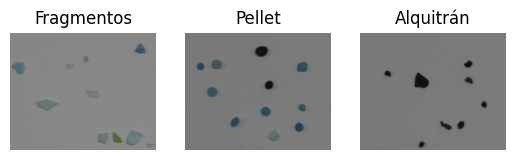

In [7]:
#Cargamos tres subimágenes de cada uno de los tres tipos considerados (el alquitrán no es microplástico)
imgF = cv2.imread('FRA.png') 
imgP = cv2.imread('PEL.png') 
imgT = cv2.imread('TAR.png') 

#Mostramos
plt.subplot(131)
plt.axis("off")
plt.imshow(imgF) 
plt.title('Fragmentos')
plt.subplot(132)
plt.axis("off")
plt.imshow(imgP) 
plt.title('Pellet')
plt.subplot(133)
plt.axis("off")
plt.imshow(imgT) 
plt.title('Alquitrán')

El objetivo de la siguiente tarea, descrita más abajo, es desarrollar tu propio clasificador basado únicamente en heurísticas desde características geométricas y/o de apariencia, para distinguir en las imágenes completas, las partículas de cada tipo, debiendo mostrar la bondad del clasificador haciendo uso de métricas para ello. La siguiente celda obtiene varias métricas para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión. La ejecución de la celda requiere instalar el paquete scikit-learn.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador para las distintas clases conocidas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente.

El siguiente ejemplo, muestra el modo de obtener la matriz de confusión para un hipotético problema con cuatro clases, y valores de anotación (variable y) y predicción (variable y_pred) obtenidos de forma aleatoria.

In [1]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


# Numero de muestras
n = 100  
nclases = 4

# A falta de clasificador y conjunto de datos, creamos anotaciones y predicciones de forma aleatoria
# Vector aleatorio con etiquetas anotadas
y = [random.randint(0, nclases - 1) for _ in range(n)]
print('Anotaciones ' , y)

# Vector aleatorio con etiquetas predichas por un supuesto clasificador
y_pred = [random.randint(0, nclases - 1) for _ in range(n)]
print('Predicciones ' , y_pred)

print('¿Cómo de bien encajan anotación y predicción?')

#Cálculo de métricas
accuracy = accuracy_score(y, y_pred)
#Para más de una clase se define la forma de promediar
precision = precision_score(y, y_pred,average='weighted')
recall = recall_score(y, y_pred,average='weighted')
f1score = f1_score(y, y_pred,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")


conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.75)#tamaños tipografía
sns.set(font_scale = 3.0)

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Real/Anotado", labelpad=20, fontdict=label_font)

ModuleNotFoundError: No module named 'seaborn'

TAREA: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

In [ ]:
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Loading the three images: fragments, pellets, and tar
frag = cv2.imread('fragment-03-olympus-10-01-2020.JPG')  
pellet = cv2.imread('pellet-03-olympus-10-01-2020.JPG')  
alqui = cv2.imread('tar-03-olympus-10-01-2020.JPG')       

# Defining the crop dimensions to avoid shadows in the images
inicio_columna = 750
fin_columna = 4000
inicio_fila = 0
fin_fila = 2700

# Cropping the images to avoid problems caused by shadows in the images
frag_gris = frag[inicio_fila:fin_fila, inicio_columna:fin_columna]     
pellet_gris = pellet[inicio_fila:fin_fila, inicio_columna:fin_columna] 
alqui_gris = alqui[inicio_fila:fin_fila, inicio_columna:fin_columna]   

# Converting the cropped images to grayscale
frag_gris = cv2.cvtColor(frag_gris, cv2.COLOR_BGR2GRAY)     
pellet_gris = cv2.cvtColor(pellet_gris, cv2.COLOR_BGR2GRAY) 
alqui_gris = cv2.cvtColor(alqui_gris, cv2.COLOR_BGR2GRAY)   

# Applying a Gaussian blur filter to the fragment image to smooth it
frag_gris = cv2.GaussianBlur(frag_gris, (25, 25), 0)  

# Displaying the  images
plt.figure(figsize=(12, 3))  

plt.subplot(131)  
plt.title('Fragmento')  
plt.axis("off")         
plt.imshow(cv2.cvtColor(frag_gris, cv2.COLOR_BGR2RGB))  

plt.subplot(132)  
plt.title('Pellet')    
plt.axis("off")        
plt.imshow(cv2.cvtColor(pellet_gris, cv2.COLOR_BGR2RGB))  

plt.subplot(133)  
plt.title('Alquitrán')  
plt.axis("off")         
plt.imshow(cv2.cvtColor(alqui_gris, cv2.COLOR_BGR2RGB))  

plt.show()  


In [ ]:
# Thresholding for 'fragments' and 'pellet'
# The threshold values had to be adjusted to avoid detecting shadows from the paper where the fragments are placed
_, frag_umbral = cv2.threshold(frag_gris, 115, 255, cv2.THRESH_BINARY_INV)  
_, pel_umbral = cv2.threshold(pellet_gris, 100, 255, cv2.THRESH_BINARY_INV) 
_, tar_umbral = cv2.threshold(alqui_gris, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)  # Thresholding using Otsu's method for 'pel'

# Display the thresholded images
plt.figure(figsize=(15, 6)) 

plt.subplot(131) 
plt.title('Fragmento') 
plt.axis("off") 
plt.imshow(frag_umbral, cmap='gray')  

plt.subplot(132) 
plt.title('Pellet')  
plt.axis("off")  
plt.imshow(pel_umbral, cmap='gray')  

plt.subplot(133)  
plt.title('Alquitrán (OTSU)') 
plt.axis("off")  
plt.imshow(tar_umbral, cmap='gray')  

plt.show()  


In [ ]:
def contar(imagen):
  
    contornos, _ = cv2.findContours(imagen, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    fragmentos, pellet, alquitran = 0, 0, 0  

    for contorno in contornos:
        area = cv2.contourArea(contorno)  
        perimetro = cv2.arcLength(contorno, True)  
        _, _, w, h = cv2.boundingRect(contorno) 
        (cx, cy), radio = cv2.minEnclosingCircle(contorno)  
        # Calculate compactness (perimeter^2 / area)
        compacidad = (perimetro ** 2) / area if area > 0 else 0

        # Initialize ellipse parameters
        eje_mayor, eje_menor, relacion_ejes_elipse, excentricidad = 0, 0, 0, 0
        if contorno.shape[0] > 5:  # Fit an ellipse only if the contour has enough points
            elipse = cv2.fitEllipse(contorno)  
            eje_mayor = elipse[1][1]  
            eje_menor = elipse[1][0]  
            relacion_ejes_elipse = eje_menor / eje_mayor 

        relacion_aspecto = w / h  # Calculate the aspect ratio of the bounding rectangle
        relacion_area_contenedor = area / (w * h)  # Calculate area ratio to bounding box area

        # Classify the contour based on compactness, aspect ratio, and area ratio
        if compacidad < 15.9 and np.isclose(relacion_aspecto, 1.0, rtol=1):
            pellet += 1 
        elif relacion_area_contenedor < 0.65 and relacion_ejes_elipse < 0.78:
            fragmentos += 1  
        else:
            alquitran += 1  

    return [fragmentos, pellet, alquitran]  

# Count the total number of fragments, pellets, and tar in the thresholded images
total_frag, total_pellet, total_alquitran = contar(frag_umbral), contar(pel_umbral), contar(tar_umbral)

# Create a confusion matrix from the counts
matriz_confusion = np.array([total_frag, total_pellet, total_alquitran])

# Plotting the confusion matrix
plt.figure(figsize=(8, 8))  
sns.set(font_scale=1.25)  
sns.heatmap(matriz_confusion, annot=True, fmt='d', cbar=False, cmap='Blues', 
            xticklabels=['Fragment', 'Pellet', 'Tar'],  
            yticklabels=['Fragment', 'Pellet', 'Tar'])  
plt.xlabel("Real Values")  
plt.ylabel("Predicted Values")  
plt.show()  
